In [1]:
using PyCall
unshift!(PyVector(pyimport("sys")["path"]), "");
@pyimport Compute_Jacobian_Anaheim
@pyimport tqdm

In [2]:
numNodes = Compute_Jacobian_Anaheim.numNodes;
numLinks = Compute_Jacobian_Anaheim.numLinks;
numODpairs = Compute_Jacobian_Anaheim.numODpairs;
numZones = Compute_Jacobian_Anaheim.numZones;
od_pairs = Compute_Jacobian_Anaheim.od_pairs;
link_list_js = Compute_Jacobian_Anaheim.link_list_js;
link_length_list = Compute_Jacobian_Anaheim.link_length_list;

In [3]:
require("prepare_data_Anaheim.jl");
require("extract_data_Anaheim.jl");
require("tap_MSA_Anaheim.jl");
require("../Julia_files/inverseVI.jl");
require("../Julia_files/demands_adjustment_gradi.jl");

In [4]:
require("initia_data.jl");

In [5]:
demandsDiffDict[1] = norm(demandsDicToVec(demandsDict[1]) - demandsDicToVec(demandsDict[0]))/
                     norm(demandsDicToVec(demandsDict[0]));

In [6]:
fcoeffs = [1, 0, 0, 0, .15];

# get observed flow vector (corresponding to ground truth demands and ground truth costs)
tapFlowDicDict[0], tapFlowVecDict[0] = tapMSA(demandsDict[0], fcoeffs);

In [7]:
# get arcs data corresponding to ground truth demands and flows
arcsDict[0] = observFlow("./benchmark_data/Anaheim_net.txt", tapFlowDicDict[0])

Dict{(Int64,Int64),Arc} with 914 entries:
  (71,255)  => Arc(71,255,1800.0,0.5,2256.856599999998)
  (323,324) => Arc(323,324,5400.0,0.5,1101.6783999999984)
  (354,353) => Arc(354,353,5400.0,1.0,8.18259999999999)
  (60,230)  => Arc(60,230,9000.0,0.333333333,2184.3118)
  (223,346) => Arc(223,346,1800.0,0.5,1407.4567999999995)
  (147,146) => Arc(147,146,7200.0,0.763320942,3563.8822000000014)
  (337,33)  => Arc(337,33,12600.0,0.149068323,6581.72060000001)
  (366,365) => Arc(366,365,5400.0,0.5,1008.6953999999995)
  (390,375) => Arc(390,375,5400.0,2.0,0.0)
  (315,316) => Arc(315,316,5400.0,2.579924242,0.0)
  (198,197) => Arc(198,197,7200.0,0.152622883,6072.444999999999)
  (333,334) => Arc(333,334,5400.0,0.420075758,1501.865800000001)
  (367,368) => Arc(367,368,5400.0,0.720075758,132.97679999999988)
  (244,339) => Arc(244,339,1800.0,0.5,1770.0333999999991)
  (274,41)  => Arc(274,41,5400.0,1.0,0.0)
  (225,330) => Arc(225,330,1800.0,0.5,997.8865999999992)
  (49,369)  => Arc(49,369,5400.0,1.0,0.

In [8]:
deg = 6
c = 3.41
lam = 1.

coeffs_dict[(deg, c, lam, 1)], objInvVIDict[1] = train(lam, deg, c, demandsDict[1], arcsDict[0]);

In [9]:
# get initial flow vector (corresponding to initial demands)
tapFlowDicDict[1], tapFlowVecDict[1] = tapMSA(demandsDict[1], coeffs_dict[(deg, c, lam, 1)]);

demandsVecDict[0] = demandsDicToVec(demandsDict[0]);

In [10]:
# get arcs data corresponding to initial demands and flows
arcsDict[1] = observFlow("./benchmark_data/Anaheim_net.txt", tapFlowDicDict[1]);

In [11]:
linkCostDicDict[1] = tapFlowVecToLinkCostDict(tapFlowVecDict[1], coeffs_dict[(deg, c, lam, 1)]);

In [12]:
linkCostDicDict[1]["0"], link_length_list[1]

(1.13517480421642,5280.0)

In [13]:
jacobiSpiessDict[1] = Compute_Jacobian_Anaheim.jacobianSpiess(numNodes, numLinks, numODpairs, od_pairs, 
                                              link_list_js, [linkCostDicDict[1]["$(i)"] for i=0:numLinks-1]);

In [14]:
# number of iterations
N = 50;  

In [15]:
for iterNumber = 1:N
    
    l = iterNumber;
    
#     jacobDict[l] = jacobian(tapFlowVecDict[l], coeffs_dict[(deg, c, lam, l)], capacity, 
#     free_flow_time, numLinks, numODpairs, numRoutes, linkRoute, odPairRoute);
    
    jacobDict[l] = jacobiSpiessDict[l]

    descDirecDict[l] = descDirec(tapFlowVecDict[l], tapFlowVecDict[0], jacobDict[l], numODpairs, numLinks);

    demandsVecDict[l] = demandsDicToVec(demandsDict[l]);

    searchDirecDict[l] = searchDirec(demandsVecDict[l], descDirecDict[l], 0);

    thetaMaxDict[l] = thetaMax(demandsVecDict[l], searchDirecDict[l]);

    objFunDict[l] = objF(demandsVecDict[l]);

    demandsVecDict[l+1] = similar(demandsVecDict[0]);
    
    demandsVecDict[l+1], objFunDict[l+1] = armijo(demandsVecDict[l], searchDirecDict[l], thetaMaxDict[l], 2, 10);
            
    demandsDict[l+1] = demandsVecToDic(demandsVecDict[l+1]);
    
    tapFlowDicDict[l+1], tapFlowVecDict[l+1] = tapMSA(demandsDict[l+1], coeffs_dict[(deg, c, lam, l)]);
        
    arcsDict[l+1] = observFlow("./benchmark_data/Anaheim_net.txt", tapFlowDicDict[l+1]);
        
#     coeffs_dict[(deg, c, lam, l+1)], objInvVIDict[l+1] = train(lam, deg, c, demandsDict[l+1], arcsDict[l+1]);
    coeffs_dict[(deg, c, lam, l+1)], objInvVIDict[l+1] = train(lam, deg, c, demandsDict[l+1], arcsDict[0]);

    linkCostDicDict[l+1] = tapFlowVecToLinkCostDict(tapFlowVecDict[l+1], coeffs_dict[(deg, c, lam, l+1)]);
    
    jacobiSpiessDict[l+1] = Compute_Jacobian_Anaheim.jacobianSpiess(numNodes, numLinks, numODpairs, od_pairs, 
                                              link_list_js, [linkCostDicDict[l+1]["$(i)"] for i=0:numLinks-1]);
        
    demandsDiffDict[l+1] = norm(demandsVecDict[l+1] - demandsVecDict[0]) / norm(demandsVecDict[0]);
        
end

# normalize objective function value
for l = 1:(N+1)
    norObjFunDict[l] = objFunDict[l] / objFunDict[1];
end

In [16]:
demandsVecDict

Dict{Int64,Array{Float64,1}} with 52 entries:
  2  => [1161.5649890887566,402.9050179811195,936.4728895768793,316.805926332174…
  11 => [1166.247618901692,404.9799433040111,938.1870711697655,320.6422530559915…
  39 => [1166.247631851147,404.9799492772308,938.1870739614844,320.6422610998231…
  46 => [1166.247631851147,404.9799492772308,938.1870739614844,320.6422610998231…
  25 => [1166.247631851147,404.9799492772308,938.1870739614844,320.6422610998231…
  42 => [1166.247631851147,404.9799492772308,938.1870739614844,320.6422610998231…
  29 => [1166.247631851147,404.9799492772308,938.1870739614844,320.6422610998231…
  8  => [1166.0311064073758,404.87952017417814,938.1417680125774,320.50883236933…
  20 => [1166.247631851147,404.9799492772308,938.1870739614844,320.6422610998231…
  14 => [1166.2476306207984,404.97994870970587,938.1870736962394,320.64226033556…
  31 => [1166.247631851147,404.9799492772308,938.1870739614844,320.6422610998231…
  33 => [1166.247631851147,404.9799492772308,938.187

In [17]:
norObjFunDict

Dict{Int64,Float64} with 51 entries:
  2  => 0.7838392151548326
  11 => 0.4533378931890501
  39 => 0.45333723392049097
  46 => 0.45333723392049097
  25 => 0.45333723392049097
  42 => 0.45333723392049097
  29 => 0.45333723392049097
  8  => 0.46368921574785743
  20 => 0.45333723392049097
  14 => 0.45333729655856947
  31 => 0.45333723392049097
  33 => 0.45333723392049097
  18 => 0.45333723392049097
  26 => 0.45333723392049097
  35 => 0.45333723392049097
  17 => 0.45333723392049097
  49 => 0.45333723392049097
  44 => 0.45333723392049097
  4  => 0.5006234774618691
  37 => 0.45333723392049097
  45 => 0.45333723392049097
  13 => 0.45333738045816985
  30 => 0.45333723392049097
  1  => 1.0
  47 => 0.45333723392049097
  ⋮   => ⋮

In [34]:
# update plots based on convergence rate
N = 20

20

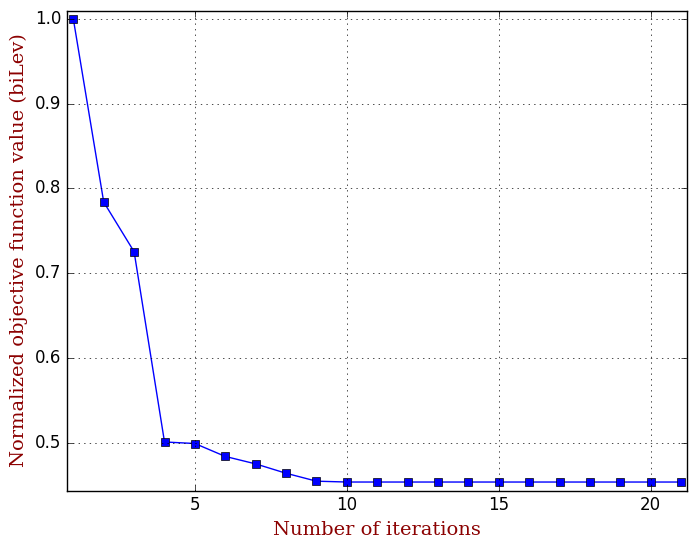

In [35]:
using PyPlot

iterNum = 1:(N+1)

objFun = map(iterNum->norObjFunDict[iterNum], iterNum)

# plot(iterNum, objFun, "s-g", label="True")

plot(iterNum, objFun, "s-b")

# legend(loc="upper right",fancybox="true") 

grid("on")

xlim(.8, N + 1 + .2)
ylim(minimum(objFun)-.01, maximum(objFun)+.01)

font1 = ["family"=>"serif", "color"=>"darkred", "weight"=>"normal", "size"=>14]

xlabel("Number of iterations", fontdict=font1)
ylabel("Normalized objective function value (biLev)", fontdict=font1)

savefig("./results/objFun_biLev_Anaheim.pdf")

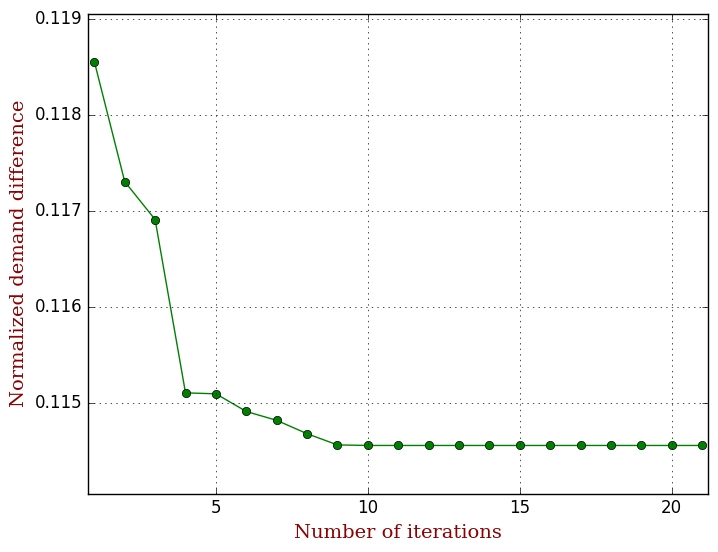

In [36]:
using PyPlot

iterNum = 1:(N+1)

demandsDiff = map(iterNum->demandsDiffDict[iterNum], iterNum)

# plot(iterNum, objFun, "s-g", label="True")

plot(iterNum, demandsDiff, "o-g")

# legend(loc="upper right",fancybox="true") 

grid("on")

xlim(.8, N + 1 + .2)
ylim(minimum(demandsDiff)-.0005, maximum(demandsDiff)+.0005)

font1 = ["family"=>"serif", "color"=>"darkred", "weight"=>"normal", "size"=>14]

xlabel("Number of iterations", fontdict=font1)
ylabel("Normalized demand difference", fontdict=font1)

savefig("./results/demandsDiff_biLev_Anaheim.pdf")

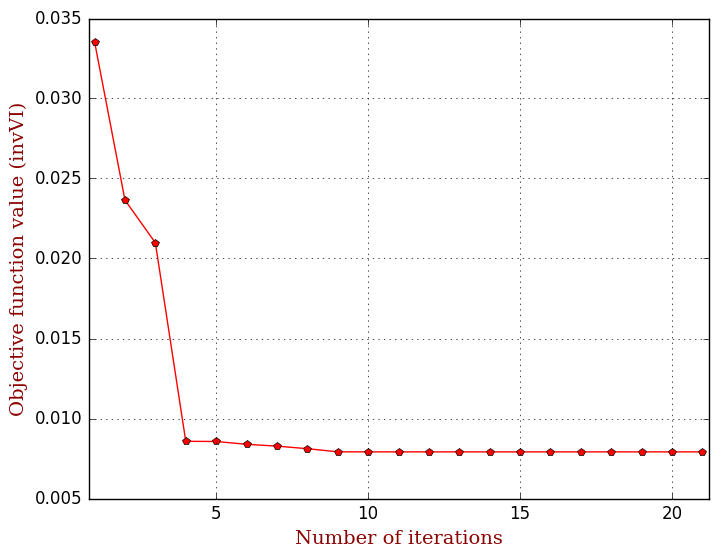

In [37]:
using PyPlot

iterNum = 1:(N+1)

objFun = map(iterNum->objInvVIDict[iterNum], iterNum)

# plot(iterNum, objFun, "s-g", label="True")

plot(iterNum, objFun, "p-r")

# legend(loc="upper right",fancybox="true") 

grid("on")

xlim(0.8, N + 1 + .2)
# ylim(0.9, 2.0)

font1 = ["family"=>"serif", "color"=>"darkred", "weight"=>"normal", "size"=>14]

xlabel("Number of iterations", fontdict=font1)
ylabel("Objective function value (invVI)", fontdict=font1)

savefig("./results/objFun_invVI_Anaheim.pdf")

In [38]:
coeffs_dict

Dict{(Int64,Float64,Float64,Int64),Array{Float64,1}} with 51 entries:
  (6,3.41,1.0,35) => [1.0,0.00951028415456761,-0.05767438505177903,0.09854022168…
  (6,3.41,1.0,8)  => [1.0,0.009491940379797914,-0.057587258494955954,0.098406023…
  (6,3.41,1.0,29) => [1.0,0.00951028415456761,-0.05767438505177903,0.09854022168…
  (6,3.41,1.0,39) => [1.0,0.00951028415456761,-0.05767438505177903,0.09854022168…
  (6,3.41,1.0,14) => [1.0,0.00951029297364412,-0.05767441842329599,0.09854023849…
  (6,3.41,1.0,9)  => [1.0,0.009509674373498327,-0.05767149264983172,0.0985357936…
  (6,3.41,1.0,12) => [1.0,0.009510293130212363,-0.05767441865204886,0.0985402367…
  (6,3.41,1.0,36) => [1.0,0.00951028415456761,-0.05767438505177903,0.09854022168…
  (6,3.41,1.0,18) => [1.0,0.00951028415456761,-0.05767438505177903,0.09854022168…
  (6,3.41,1.0,48) => [1.0,0.00951028415456761,-0.05767438505177903,0.09854022168…
  (6,3.41,1.0,23) => [1.0,0.00951028415456761,-0.05767438505177903,0.09854022168…
  (6,3.41,1.0,6)  => [1.0,0.

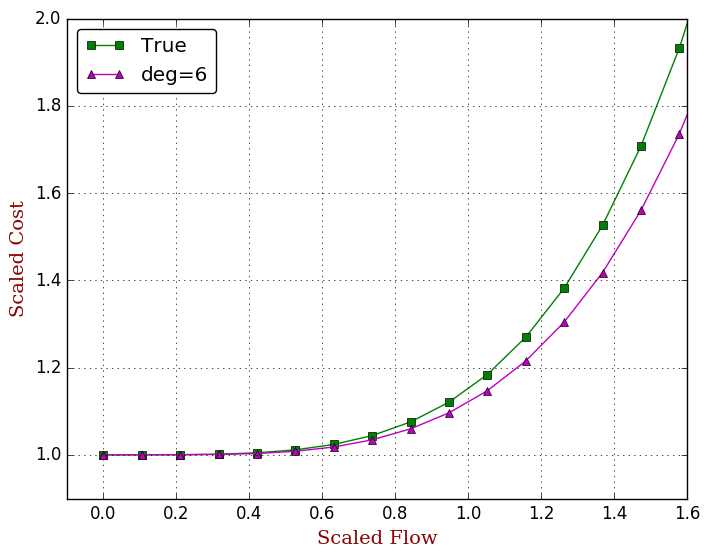

In [39]:
using PyPlot

iterN = 1

true_coeffs = [1, 0, 0, 0, .15]
# true_coeffs = [1, .2, .5, .8, .15]

est_coeffs = coeffs_dict[(6, 3.41, 1., iterN)]

xs = linspace(0, 2, 20)
zs_true = map(x->polyEval(true_coeffs, x), xs)

zs = map(x->polyEval(est_coeffs, x), xs)

plot(xs, zs_true, "s-g", label="True")

plot(xs, zs, "^-m", label="deg=6")
legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.6);
ylim(0.9, 2.0);

font1 = ["family"=>"serif","color"=>"darkred","weight"=>"normal","size"=>14]
xlabel("Scaled Flow", fontdict=font1)
ylabel("Scaled Cost", fontdict=font1)

savefig("./results/fitting_Anaheim_iter_$(iterN).pdf")

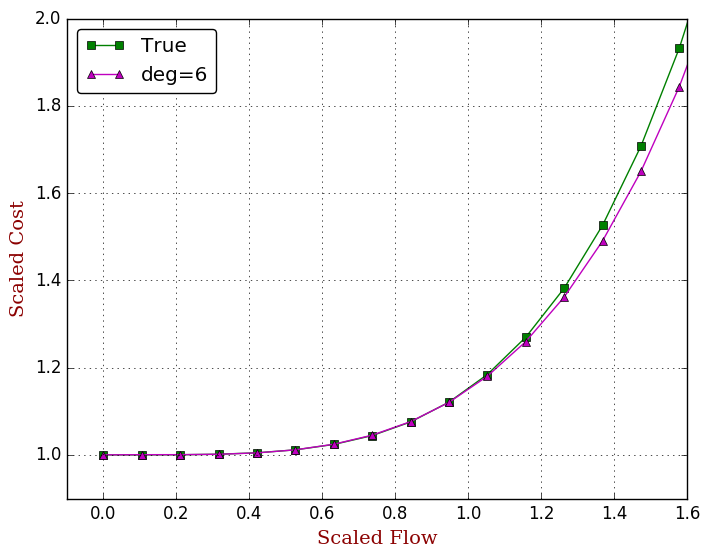

In [40]:
using PyPlot

iterN = 2

true_coeffs = [1, 0, 0, 0, .15]
# true_coeffs = [1, .2, .5, .8, .15]

est_coeffs = coeffs_dict[(6, 3.41, 1., iterN)]

xs = linspace(0, 2, 20)
zs_true = map(x->polyEval(true_coeffs, x), xs)

zs = map(x->polyEval(est_coeffs, x), xs)

plot(xs, zs_true, "s-g", label="True")

plot(xs, zs, "^-m", label="deg=6")
legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.6);
ylim(0.9, 2.0);

font1 = ["family"=>"serif","color"=>"darkred","weight"=>"normal","size"=>14]
xlabel("Scaled Flow", fontdict=font1)
ylabel("Scaled Cost", fontdict=font1)

savefig("./results/fitting_Anaheim_iter_$(iterN).pdf")

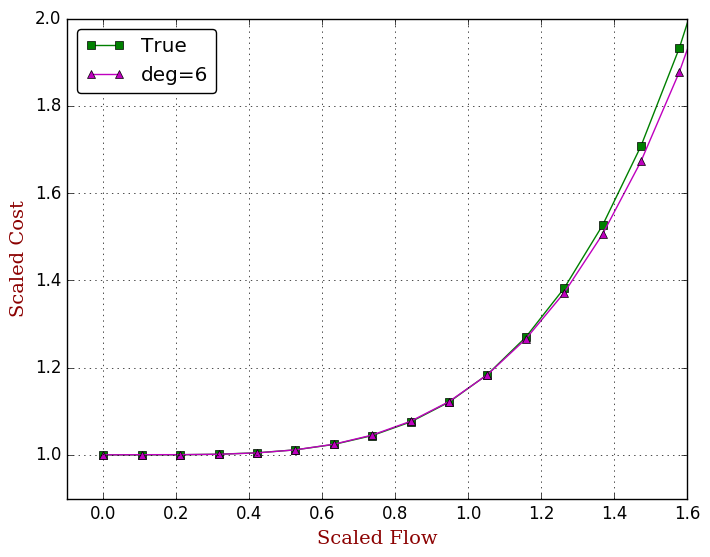

In [41]:
using PyPlot

iterN = 3

true_coeffs = [1, 0, 0, 0, .15]
# true_coeffs = [1, .2, .5, .8, .15]

est_coeffs = coeffs_dict[(6, 3.41, 1., iterN)]

xs = linspace(0, 2, 20)
zs_true = map(x->polyEval(true_coeffs, x), xs)

zs = map(x->polyEval(est_coeffs, x), xs)

plot(xs, zs_true, "s-g", label="True")

plot(xs, zs, "^-m", label="deg=6")
legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.6);
ylim(0.9, 2.0);

font1 = ["family"=>"serif","color"=>"darkred","weight"=>"normal","size"=>14]
xlabel("Scaled Flow", fontdict=font1)
ylabel("Scaled Cost", fontdict=font1)

savefig("./results/fitting_Anaheim_iter_$(iterN).pdf")

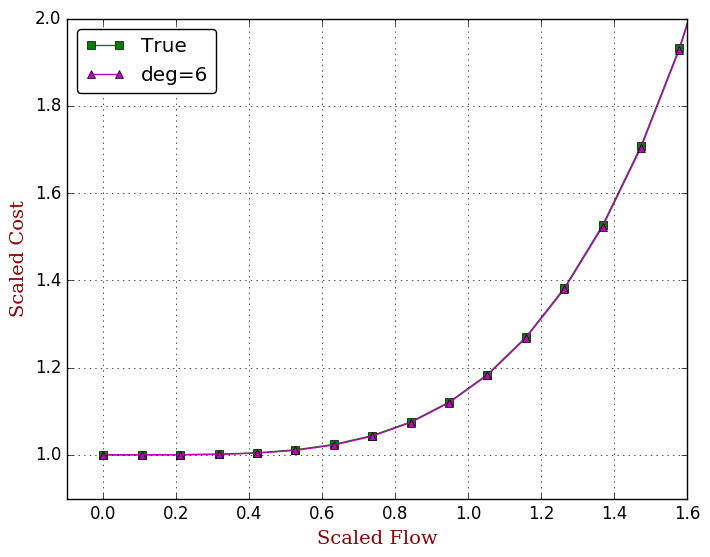

In [42]:
using PyPlot

iterN = N+1

true_coeffs = [1, 0, 0, 0, .15]
# true_coeffs = [1, .2, .5, .8, .15]

est_coeffs = coeffs_dict[(6, 3.41, 1., iterN)]

xs = linspace(0, 2, 20)
zs_true = map(x->polyEval(true_coeffs, x), xs)

zs = map(x->polyEval(est_coeffs, x), xs)

plot(xs, zs_true, "s-g", label="True")

plot(xs, zs, "^-m", label="deg=6")
legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.6);
ylim(0.9, 2.0);

font1 = ["family"=>"serif","color"=>"darkred","weight"=>"normal","size"=>14]
xlabel("Scaled Flow", fontdict=font1)
ylabel("Scaled Cost", fontdict=font1)

savefig("./results/fitting_Anaheim_iter_$(iterN).pdf")

In [26]:
outfile = open("./results/norObjFunDict.json", "w")

JSON.print(outfile, norObjFunDict)

close(outfile)

In [27]:
outfile = open("./results/demandsDiffDict.json", "w")

JSON.print(outfile, demandsDiffDict)

close(outfile)

In [28]:
outfile = open("./results/objInvVIDict.json", "w")

JSON.print(outfile, objInvVIDict)

close(outfile)

In [29]:
outfile = open("./results/coeffs_dict.json", "w")

JSON.print(outfile, coeffs_dict)

close(outfile)

In [30]:
outfile = open("./results/demandsVecDict.json", "w")

JSON.print(outfile, demandsVecDict)

close(outfile)

In [31]:
outfile = open("./results/demandsDict.json", "w")

JSON.print(outfile, demandsDict)

close(outfile)

In [32]:
outfile = open("./results/tapFlowDicDict.json", "w")

JSON.print(outfile, tapFlowDicDict)

close(outfile)

In [33]:
outfile = open("./results/tapFlowVecDict.json", "w")

JSON.print(outfile, tapFlowVecDict)

close(outfile)